# Clasificador Binario

## Librerías

In [1]:
!pip install fastai -Uq

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [2]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-18 16:18:29 URL:https://uc37869bcfc4277555d995a63518.dl.dropboxusercontent.com/cd/0/inline2/BnfB_0D2Ac3RPdCITIt_YUyB2d-CiGpXzKc10kRKlfRXM_LNQPCAzxPRwvq3VPzJ8KZ46tO3A4apcq67vN1pU01o8bCk4YzwWR0i4p75YwjF9ubr9lJANud0ivdS1ogJ-33-d10d6epbv97XvZ0Fh8dXTrMfkv62F5BFM1i64Ea-6xLqUgSyOpVQfJh5ObK3bC66pkSRfGDw2DIfWpaLtqMqcxlvQOob09BlenxWogdhtONGLAYNbxBGCVuRQW1f5M4YKvILarCtfAwtAWm2Mpoe5SGcxLIzsguIauKAEingbod661g2F5RACuWUmJlWS3jNm2B5ZdLnXYH3gqFQjAvZ-XGq6Ukz9xnEEApJurQQ-OTO2Lubt-wKR6ECe9_D2ZA1kIRaGxy3t3VWyVyJ0tW6Ecfu6tjd97yR4ZImSBlo4A/file [138777773/138777773] -> "train.zip" [1]
2022-06-18 16:18:33 URL:https://ucad6c40aac5c3c149b134c8a960.dl.dropboxusercontent.com/cd/0/inline2/Bnc0neiThRCtHuFXQPoT0zIVTAFbcfR5AXHWdrk8vEN4s-q96Ke1n0XmSAPxzSb_QQNPjhCJofYMs2FtAVaHRV5wHSS5FFeqmIUHufgl9vAwxaOdupxVHC69gzi3OhI0ZwySCQQJuyx28PCCHrf9nG7FoNTQHP8JBuQ_HLwOfHk-cciimWAxlK8AgW6X5ecpTk_QQdaJjKpj4mgM9MGNKb5WbFQm0WgJCD8oayeAGT_kNB-jNjERc4n1t6GB8AuSLjPYv-moGUlYM2aZInEVcSOvlNxZI8B-kjgnL_8GWDoo-Pp5tIiU817vIDpifxLfx1x

In [3]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [4]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [5]:
crearEstructura('dataset', ['normal', 'enfermedad'])

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [6]:
path = Path('dataset/')

In [7]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [8]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [9]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [10]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Repetimos esto para los tres conjuntos.

In [11]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [12]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

In [13]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

0

In [14]:
len(Path('dataset/train/normal').ls()) #401

401

Ahora que ya tenemos la estructura deseado empezamos a construir el modelo:

## Cargando el dataset

In [15]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [16]:
dls = db.dataloaders(path,bs=128)

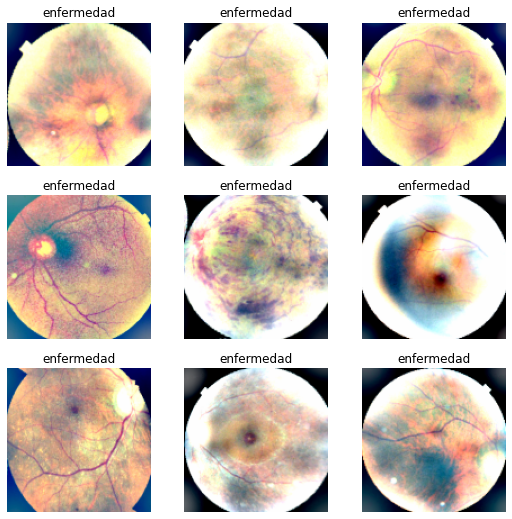

In [17]:
dls.show_batch()

In [19]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')
]

In [26]:
metrics=[ accuracy, Precision(), Recall(), F1Score(), error_rate ]
learn = cnn_learner(dls,resnet18, metrics=metrics, cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(minimum=0.010000000149011612, steep=0.0006918309954926372, valley=0.0005754399462603033, slide=0.0063095735386013985)

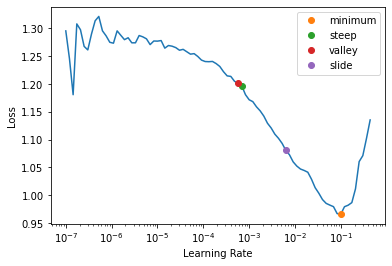

In [24]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.046050,0.800861,0.751562,0.452830,0.895522,0.601504,0.248437,00:09


Better model found at epoch 0 with valid_loss value: 0.8008610010147095.


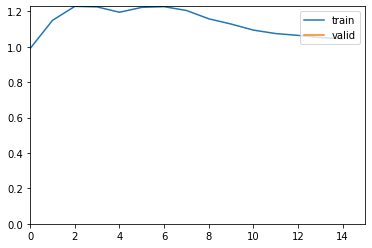

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,0.852391,0.826215,0.673437,0.378641,0.873134,0.528217,0.326562,00:09
1,0.809337,0.710670,0.717188,0.414545,0.850746,0.557457,0.282813,00:09
2,0.781437,0.616430,0.771875,0.475000,0.850746,0.609626,0.228125,00:11
3,0.755376,0.633004,0.773438,0.476793,0.843284,0.609164,0.226562,00:09
4,0.740463,0.653566,0.767187,0.468619,0.835821,0.600536,0.232812,00:09
5,0.718380,0.682061,0.757812,0.457490,0.843284,0.593176,0.242188,00:09
6,0.685133,0.669793,0.779688,0.485106,0.850746,0.617886,0.220313,00:09
7,0.665049,0.552054,0.821875,0.549505,0.828358,0.660714,0.178125,00:09
8,0.636607,0.569637,0.828125,0.560000,0.835821,0.670659,0.171875,00:09
9,0.600329,0.516920,0.832812,0.573770,0.783582,0.662461,0.167187,00:09


Better model found at epoch 0 with valid_loss value: 0.8262151479721069.


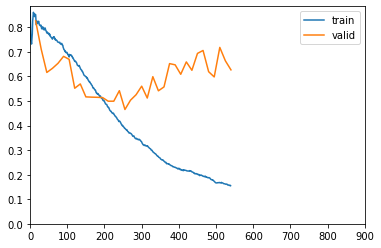

Better model found at epoch 1 with valid_loss value: 0.7106701731681824.
Better model found at epoch 2 with valid_loss value: 0.6164303421974182.
Better model found at epoch 7 with valid_loss value: 0.5520536303520203.
Better model found at epoch 9 with valid_loss value: 0.5169199705123901.
Better model found at epoch 10 with valid_loss value: 0.5158933401107788.
Better model found at epoch 11 with valid_loss value: 0.5152314901351929.
Better model found at epoch 12 with valid_loss value: 0.5140728950500488.
Better model found at epoch 13 with valid_loss value: 0.49935466051101685.
Better model found at epoch 16 with valid_loss value: 0.46557798981666565.
No improvement since epoch 16: early stopping


In [27]:
%%time
learn.fine_tune(60,base_lr=1e-3)

Exportamos el modelo

In [34]:
learn.to_fp32()
learn.export('Binario_CEL_resnet18.pkl')

## Evaluando el modelo

In [29]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [30]:
learn.dls = dlsTest

In [31]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.8921874761581421.


(#6) [0.31656068563461304,0.8921874761581421,0.8037383177570093,0.6417910447761194,0.7136929460580912,0.10781250149011612]

## Interpretación del modelo

In [32]:
learn.dls=dls

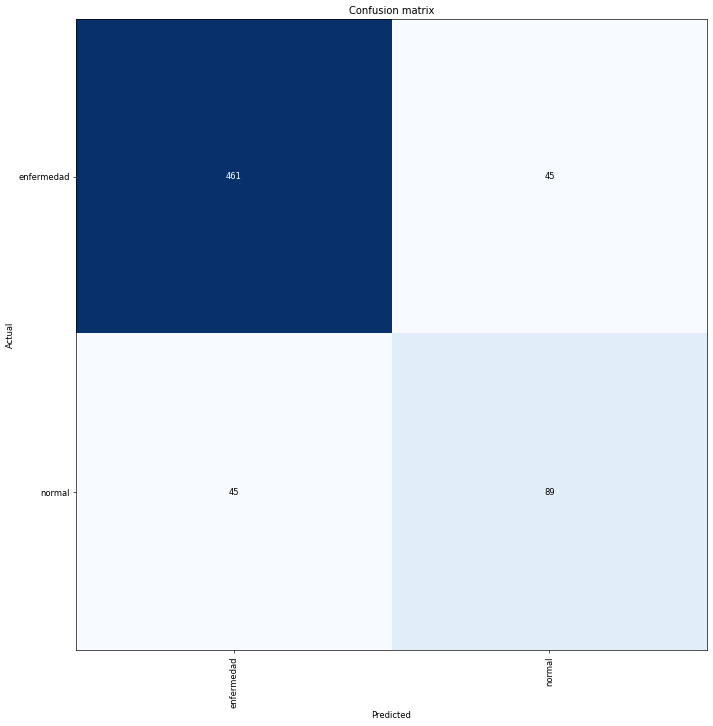

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)